In [1]:
!pip install scikit-learn
!pip install tensorflow
!pip install tensorflow_datasets
!pip install matplotlib
!pip install seaborn


  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached Markdown-3.7-py3-none-any.whl.metadata (7.0 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 MB 5.1 MB/s eta 0:00:0000:0100:02
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 6.8 MB/s eta 0:00:00 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 5.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 4.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 5.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import tensorflow_datasets as tfds
import tensorflow as tf


In [3]:

dataset, info = tfds.load('caltech101', with_info=True, as_supervised=True)


2024-11-03 13:18:28.692184: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


/opt/anaconda3/envs/Computer-vision/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [03:08<00:00, 188.22s/ url]

Extraction completed...: 100%|██████████| 9145/9145 [00:11<00:00, 814.81 file/s]  
                                                                        

Dataset caltech101 downloaded and prepared to /Users/mac/tensorflow_datasets/caltech101/3.0.2. Subsequent calls will reuse this data.


In [5]:
train_dataset = dataset['train']
test_dataset = dataset['test']


In [7]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (128, 128))  # Thay đổi kích thước hình ảnh
    image = tf.image.rgb_to_grayscale(image)    # Chuyển thành ảnh grayscale
    image = tf.reshape(image, (128*128))        # Chuyển thành vector
    return image, label
X_train = []
y_train = []
for image, label in tfds.as_numpy(train_dataset):
    img, lbl = preprocess_image(image, label)
    X_train.append(img)
    y_train.append(lbl)

X_test = []
y_test = []
for image, label in tfds.as_numpy(test_dataset):
    img, lbl = preprocess_image(image, label)
    X_test.append(img)
    y_test.append(lbl)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


2024-11-03 13:23:41.171779: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-03 13:23:45.882580: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)  # 75% train, 25% validation


total_samples = len(X_train) + len(X_val) + len(X_test)
train_size = int(0.6 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

X = np.concatenate((X_train, X_val, X_test))
y = np.concatenate((y_train, y_val, y_test))

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, train_size=train_size, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=test_size, random_state=42)


In [9]:

k_values = [1, 2, 3, 4, 5]

accuracy_val = []
accuracy_test = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_val_pred = knn.predict(X_val)
    acc_val = accuracy_score(y_val, y_val_pred)
    accuracy_val.append(acc_val)
    y_test_pred = knn.predict(X_test)
    acc_test = accuracy_score(y_test, y_test_pred)
    accuracy_test.append(acc_test)
    
    print(f'K={k}: Validation Accuracy={acc_val:.4f}, Test Accuracy={acc_test:.4f}')


K=1: Validation Accuracy=0.3206, Test Accuracy=0.3437
K=2: Validation Accuracy=0.3102, Test Accuracy=0.3372
K=3: Validation Accuracy=0.3124, Test Accuracy=0.3404
K=4: Validation Accuracy=0.3135, Test Accuracy=0.3432
K=5: Validation Accuracy=0.3200, Test Accuracy=0.3464


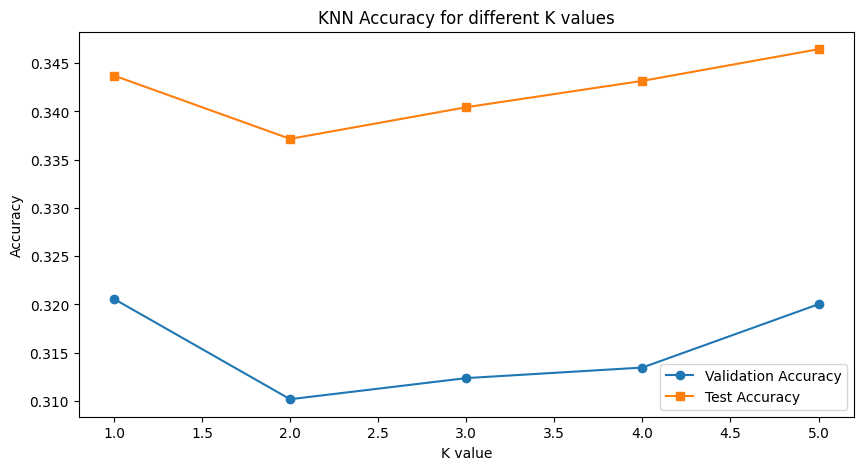

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracy_val, label='Validation Accuracy', marker='o')
plt.plot(k_values, accuracy_test, label='Test Accuracy', marker='s')
plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for different K values')
plt.legend()
plt.show()


In [11]:
# Khởi tạo mô hình SVC với C=1
svc = SVC(C=1, kernel='linear', decision_function_shape='ovr')
svc.fit(X_train, y_train)
y_test_pred = svc.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy with SVC (C=1): {acc_test:.4f}')
precision_per_class = precision_score(y_test, y_test_pred, average=None)

for i, precision in enumerate(precision_per_class):
    print(f'Class {i}: Precision={precision:.4f}')


Test Accuracy with SVC (C=1): 0.3962
Class 0: Precision=0.6364
Class 1: Precision=0.7033
Class 2: Precision=0.5000
Class 3: Precision=0.0000
Class 4: Precision=0.1268
Class 5: Precision=0.0000
Class 6: Precision=0.0000
Class 7: Precision=0.0000
Class 8: Precision=0.0000
Class 9: Precision=0.2500
Class 10: Precision=0.3333
Class 11: Precision=0.2500
Class 12: Precision=0.4286
Class 13: Precision=0.1538
Class 14: Precision=0.2000
Class 15: Precision=0.0000
Class 16: Precision=0.2791
Class 17: Precision=0.0000
Class 18: Precision=0.7000
Class 19: Precision=0.1250
Class 20: Precision=0.2143
Class 21: Precision=0.2000
Class 22: Precision=0.2222
Class 23: Precision=0.2000
Class 24: Precision=0.2941
Class 25: Precision=0.0000
Class 26: Precision=0.0000
Class 27: Precision=0.0667
Class 28: Precision=0.2857
Class 29: Precision=0.8000
Class 30: Precision=0.0800
Class 31: Precision=0.0833
Class 32: Precision=0.1053
Class 33: Precision=0.0714
Class 34: Precision=0.0000
Class 35: Precision=0.6000
C

/opt/anaconda3/envs/Computer-vision/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy with SVC One-vs-One: 0.3962
Number of support vectors for each class: [ 30 328  23  24 296  27  32  27  15  72  59  20  45  54  33  26  76  34
  37  39  63  28  47  39  41  24  27  30  40  25  35  45  50  33  30  35
  44 235 140  34  35  30  24  24  33  52  48  19  34  55  53  23  41  49
  65  40  46 108  47  22  38  26  27  56  21  44 210  34  22  20  27  22
  26  35  24  34  52  34  28  25  45  20  58  30  21  40  27  49  39  36
  25  50  29  49  48 154  25  33  22  33  23  27]


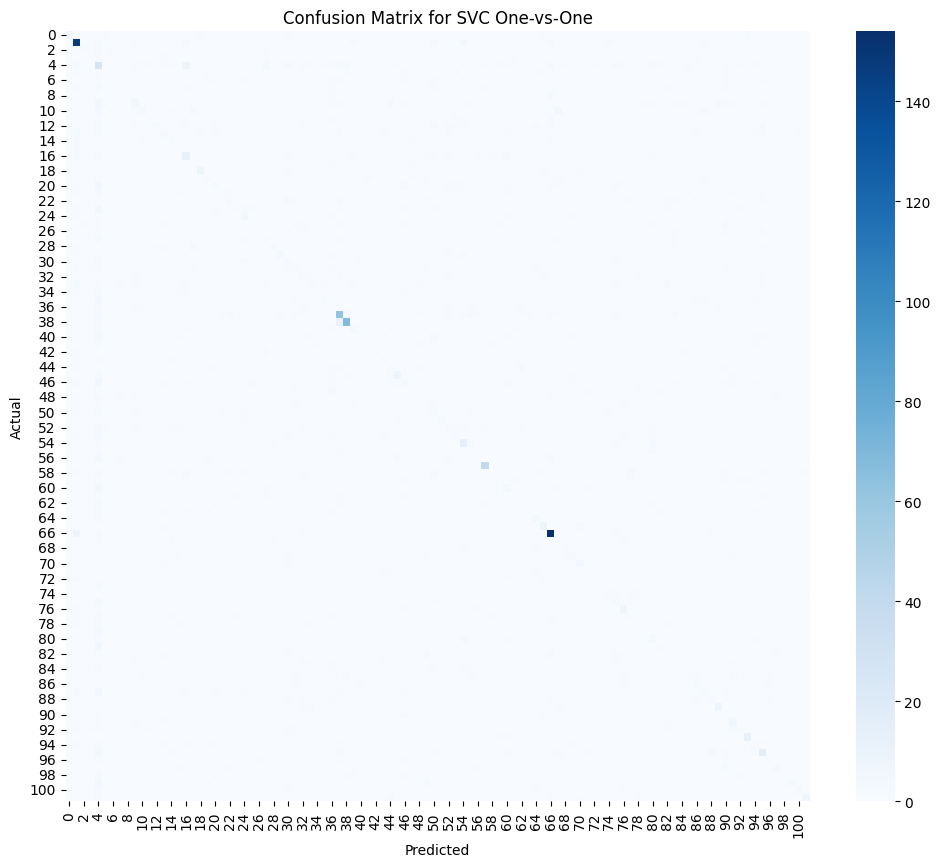

In [12]:
svc_ovo = SVC(C=1, kernel='linear', decision_function_shape='ovo')
svc_ovo.fit(X_train, y_train)
y_test_pred_ovo = svc_ovo.predict(X_test)
acc_test_ovo = accuracy_score(y_test, y_test_pred_ovo)
print(f'Test Accuracy with SVC One-vs-One: {acc_test_ovo:.4f}')

num_support_vectors = svc_ovo.n_support_
print(f'Number of support vectors for each class: {num_support_vectors}')
conf_matrix = confusion_matrix(y_test, y_test_pred_ovo)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for SVC One-vs-One')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Test Accuracy with SVC One-vs-Rest: 0.3962
Number of support vectors for each class: [ 30 328  23  24 296  27  32  27  15  72  59  20  45  54  33  26  76  34
  37  39  63  28  47  39  41  24  27  30  40  25  35  45  50  33  30  35
  44 235 140  34  35  30  24  24  33  52  48  19  34  55  53  23  41  49
  65  40  46 108  47  22  38  26  27  56  21  44 210  34  22  20  27  22
  26  35  24  34  52  34  28  25  45  20  58  30  21  40  27  49  39  36
  25  50  29  49  48 154  25  33  22  33  23  27]


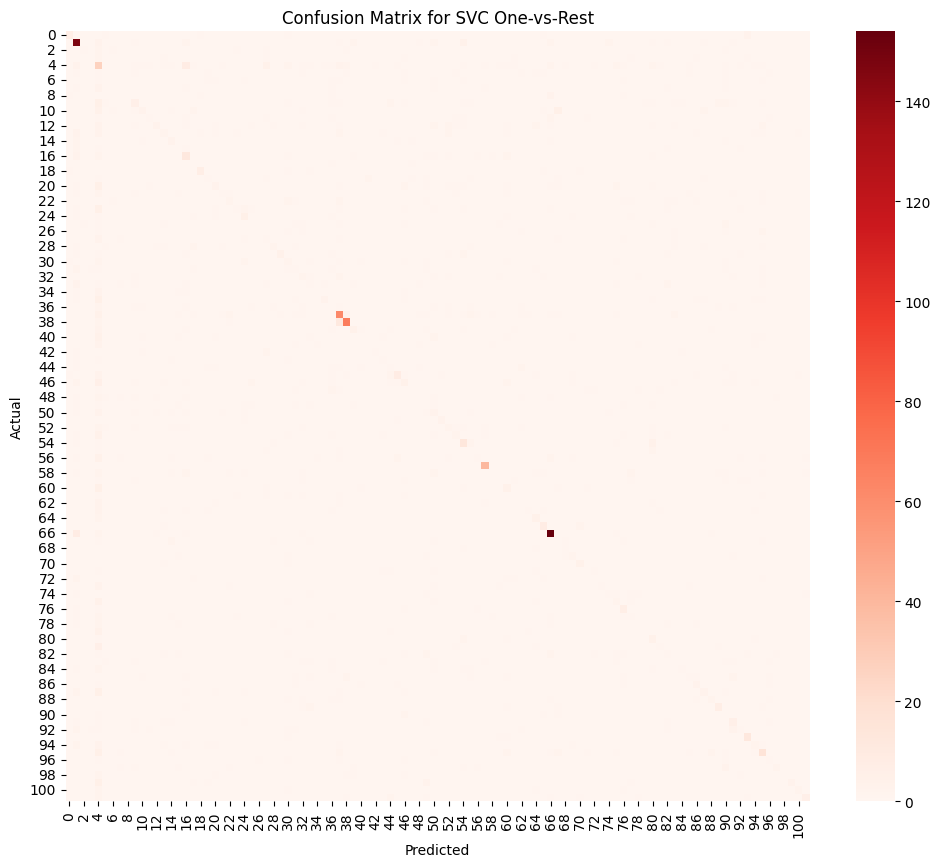

In [13]:
svc_ovr = SVC(C=1, kernel='linear', decision_function_shape='ovr')
svc_ovr.fit(X_train, y_train)
y_test_pred_ovr = svc_ovr.predict(X_test)
acc_test_ovr = accuracy_score(y_test, y_test_pred_ovr)
print(f'Test Accuracy with SVC One-vs-Rest: {acc_test_ovr:.4f}')
num_support_vectors_ovr = svc_ovr.n_support_
print(f'Number of support vectors for each class: {num_support_vectors_ovr}')
conf_matrix_ovr = confusion_matrix(y_test, y_test_pred_ovr)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_ovr, annot=False, fmt='d', cmap='Reds')
plt.title('Confusion Matrix for SVC One-vs-Rest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [14]:
C_values = [0.1, 1, 10, 100, 1000]
param_grid = {'C': C_values}
grid_search = GridSearchCV(SVC(kernel='linear'), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_C = grid_search.best_params_['C']
print(f'Best C value: {best_C}')
svc_best = SVC(C=best_C, kernel='linear')
svc_best.fit(X_train, y_train)
y_test_pred_best = svc_best.predict(X_test)
acc_test_best = accuracy_score(y_test, y_test_pred_best)
print(f'Test Accuracy with best C ({best_C}): {acc_test_best:.4f}')


Best C value: 0.1
Test Accuracy with best C (0.1): 0.3962
